#### Sprint 3: Model Development and Evaluation

In [1]:
# load dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [2]:
# load dataset
df = pd.read_csv("data/cleaned_dataset.csv")

In [3]:
# feature selection and target variable
target = "Base Price"
features = [
    "Property ID", "Property Type", "Building Size - GIA (M2)", "Site Area (Hectares)", 
    "Occupied by Council / Direct Service Property", "Council Tax", "New Price", "Price Per Sq Meter", "Property History Count"
]

In [4]:
# Drop rows with missing target values
df = df.dropna(subset=[target])

In [5]:
# Ensure the categorical columns exist before encoding
categorical_cols = ["Property Type", "Occupied by Council / Direct Service Property"]
existing_categorical_cols = [col for col in categorical_cols if col in df.columns]

# Convert categorical features into numerical values
df = pd.get_dummies(df, columns=existing_categorical_cols, drop_first=True)

# Update features list to exclude missing ones
features = [col for col in features if col in df.columns]

In [6]:
# Splitting data into training and testing 
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print("Missing values in X_train:\n", pd.DataFrame(X_train).isna().sum())
print("Missing values in X_test:\n", pd.DataFrame(X_test).isna().sum())
print("Infinite values in X_train:", np.isinf(X_train).sum())
print("Infinite values in X_test:", np.isinf(X_test).sum())

Missing values in X_train:
 Property ID                   0
Building Size - GIA (M2)      0
Site Area (Hectares)          1
Council Tax                   0
New Price                   111
Price Per Sq Meter            0
Property History Count        0
dtype: int64
Missing values in X_test:
 Property ID                  0
Building Size - GIA (M2)     0
Site Area (Hectares)         0
Council Tax                  0
New Price                   28
Price Per Sq Meter           0
Property History Count       0
dtype: int64
Infinite values in X_train: Property ID                 0
Building Size - GIA (M2)    0
Site Area (Hectares)        0
Council Tax                 0
New Price                   0
Price Per Sq Meter          0
Property History Count      0
dtype: int64
Infinite values in X_test: Property ID                 0
Building Size - GIA (M2)    0
Site Area (Hectares)        0
Council Tax                 0
New Price                   0
Price Per Sq Meter          0
Property History Cou

In [8]:
# Check for NaN or infinite values
if X.isnull().values.any():
    print("Warning: NaN values found in X. Consider imputing or dropping them.")
    X = X.fillna(0)  # or X.dropna()

if np.isinf(X.values).any():
    print("Warning: Infinite values found in X. Replacing with NaN.")
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X = X.fillna(0)  # Handle NaNs after replacement

# Check for zero-variance features and remove them
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.0)
X = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])

# Proceed with train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handling NaN values before scaling
X_train = X_train.fillna(X_train.mean())  # Fill missing values with column mean
X_test = X_test.fillna(X_train.mean())  # Use training mean to avoid data leakage

# Standardizing numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# model training functions
def train_and_evaluate(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name}: RMSE = {rmse:.2f}, R^2 = {r2:.2f}")
    return model, rmse, r2

In [10]:
# Initializing Models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [11]:
# Training and Evaluating Models
results = {}
for name, model in models.items():
    trained_model, rmse, r2 = train_and_evaluate(model, name)
    results[name] = {"model": trained_model, "RMSE": rmse, "R2": r2}

Linear Regression: RMSE = 118320.61, R^2 = 0.81
Lasso Regression: RMSE = 118320.58, R^2 = 0.81
Random Forest: RMSE = 107159.51, R^2 = 0.84
XGBoost: RMSE = 191156.07, R^2 = 0.49


In [12]:
# hyperparameter Tuning for XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(XGBRegressor(random_state=42), xgb_params, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
print(f"Best XGBoost Model: {grid_search.best_params_}")

Best XGBoost Model: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


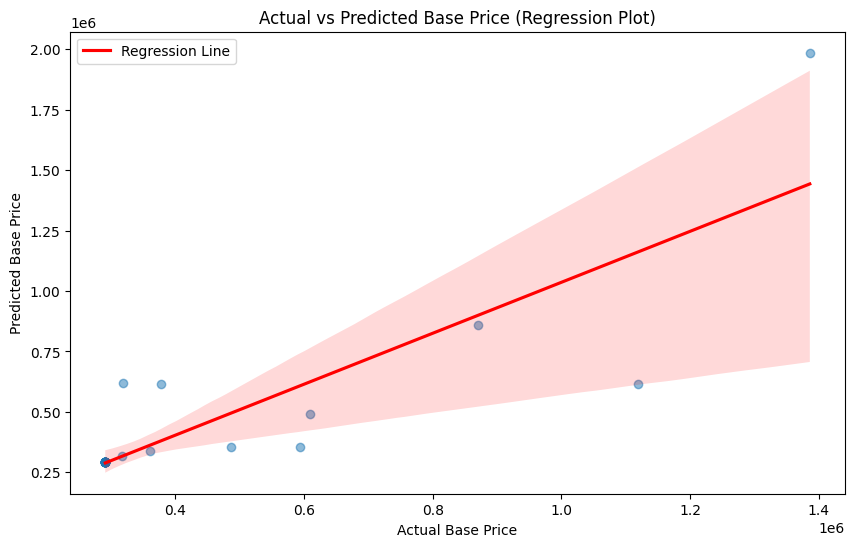

In [19]:
# create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={"alpha": 0.5, "label": "Actual vs Predicted"}, line_kws={"color": "red", "label": "Regression Line"})

# Labels and title
plt.xlabel("Actual Base Price")
plt.ylabel("Predicted Base Price")
plt.title("Actual vs Predicted Base Price (Regression Plot)")

# add legend
plt.legend()

# show the plot
plt.show()

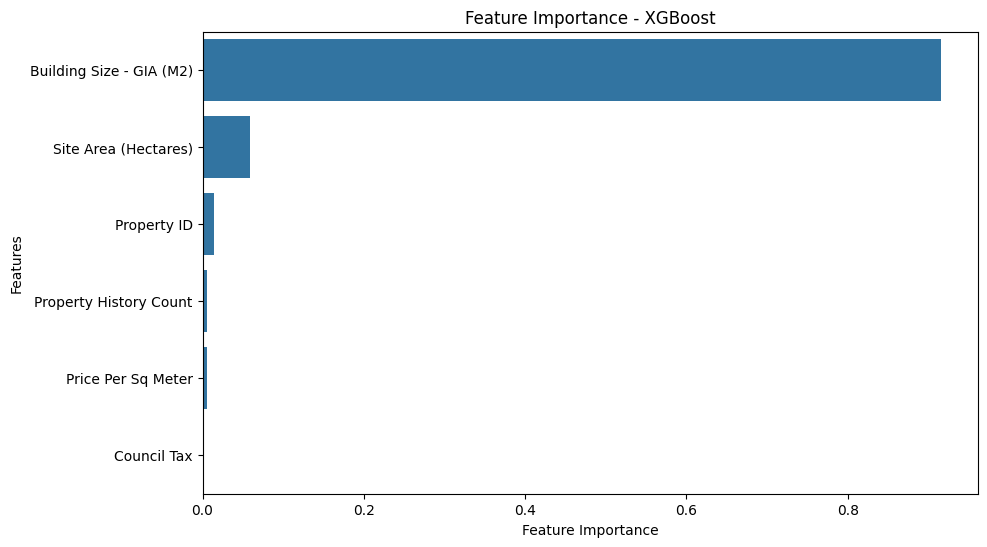

In [13]:
# feature importance analytics 
feature_importances = best_xgb.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_indices], y=np.array(feature_names)[sorted_indices])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance - XGBoost")
plt.show()

<Figure size 800x500 with 0 Axes>

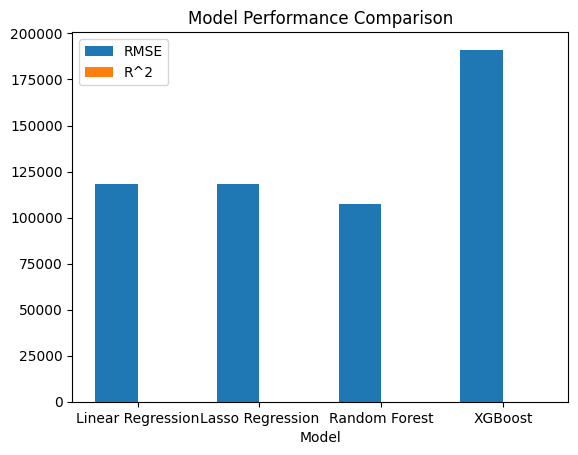

In [40]:
# model performance visualization
plt.figure(figsize=(8,5))
rmse_values = [results[name]["RMSE"] for name in results]
r2_values = [results[name]["R2"] for name in results]
names = list(results.keys())

x = np.arange(len(names))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rmse_values, width, label="RMSE")
rects2 = ax.bar(x + width/2, r2_values, width, label='R^2')

ax.set_xlabel("Model")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()
plt.show()

In [14]:
# Saving the model
joblib.dump(best_xgb, "property_price_model.pkl")
print("Model saved as property_price_model.pkl")

Model saved as property_price_model.pkl
